# Import

In [3]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from datetime import datetime, date, timedelta
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
#import enefit
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
plt.rcParams.update(**{'figure.dpi': 150})

In [4]:
train= pd.read_csv('/Users/mingchen/Desktop/predict-energy-behavior-of-prosumers/train.csv',parse_dates=['datetime'])
gas_df= pd.read_csv('/Users/mingchen/Desktop/predict-energy-behavior-of-prosumers/gas_prices.csv')
electricity_df= pd.read_csv('/Users/mingchen/Desktop/predict-energy-behavior-of-prosumers/electricity_prices.csv')
client_df= pd.read_csv('/Users/mingchen/Desktop/predict-energy-behavior-of-prosumers/client.csv')
fw_df= pd.read_csv('/Users/mingchen/Desktop/predict-energy-behavior-of-prosumers/forecast_weather.csv')
hw_df= pd.read_csv('/Users/mingchen/Desktop/predict-energy-behavior-of-prosumers/historical_weather.csv')
counties = gpd.read_file('/Users/mingchen/Desktop/predict-energy-behavior-of-prosumers/maakond_shp/maakond_20231201.shp')
locations = pd.read_csv('/Users/mingchen/Desktop/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv')

# EDA

## Frequency for county, prosumer type, product type

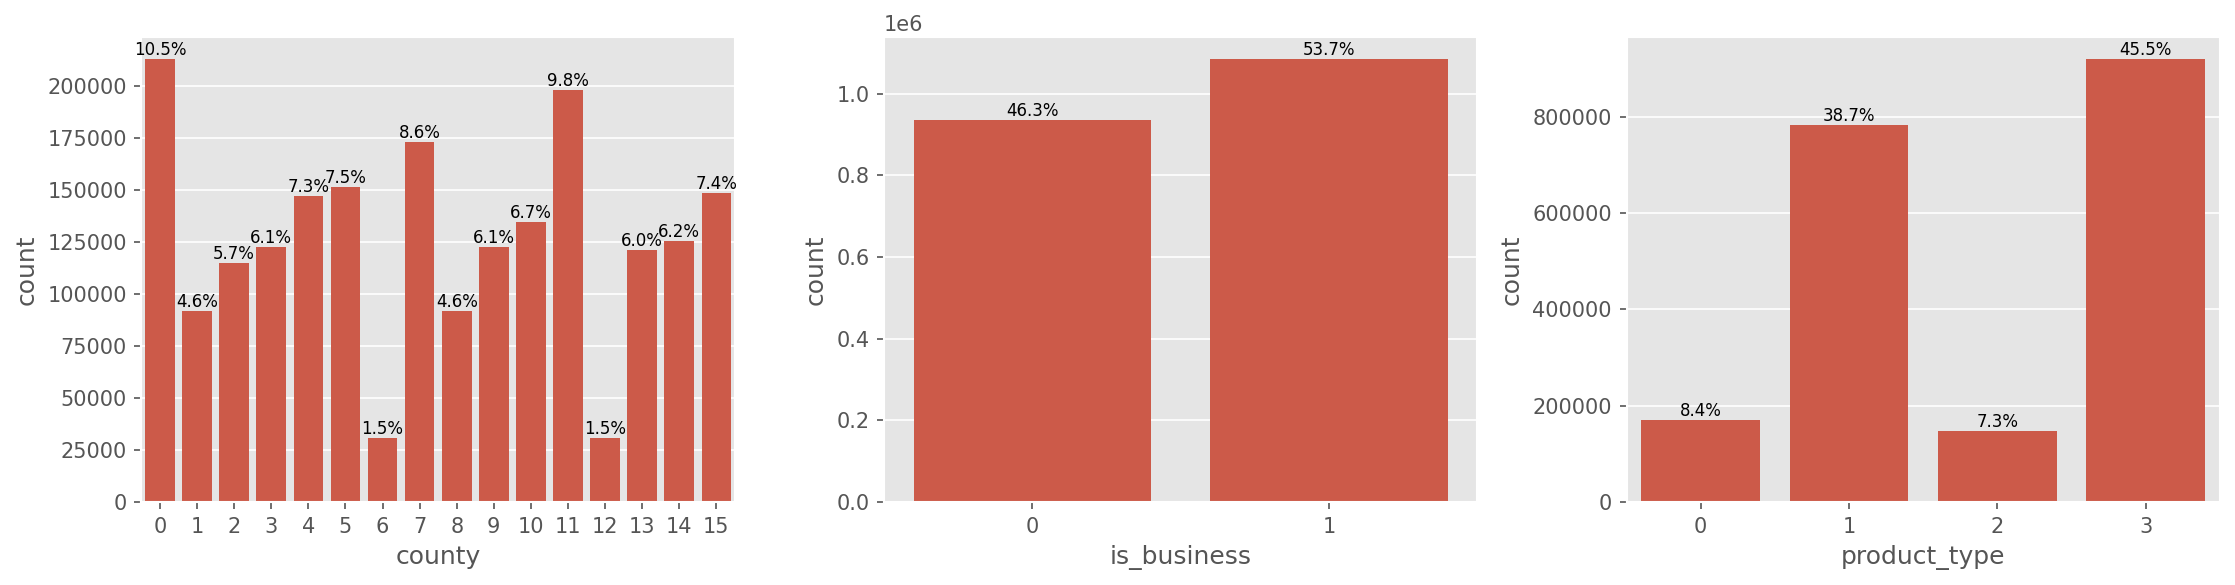

In [159]:
desc_columns = ['county','is_business','product_type']

fig, axs = plt.subplots(1, len(desc_columns), figsize=(5*len(desc_columns), 4))

for i, column in enumerate(desc_columns):
     sns.countplot(train, x=column, ax=axs[i])
     total = len(train[column])
     for p in axs[i].patches:
          percentage = '{:.1f}%'.format(100 * p.get_height() / total)
          x = p.get_x() + p.get_width() / 2
          y = p.get_height()
          axs[i].annotate(percentage, (x, y), ha='center', va='bottom', fontsize=8)

fig.tight_layout()

## Production for County 0's individual prosumers by product type over time

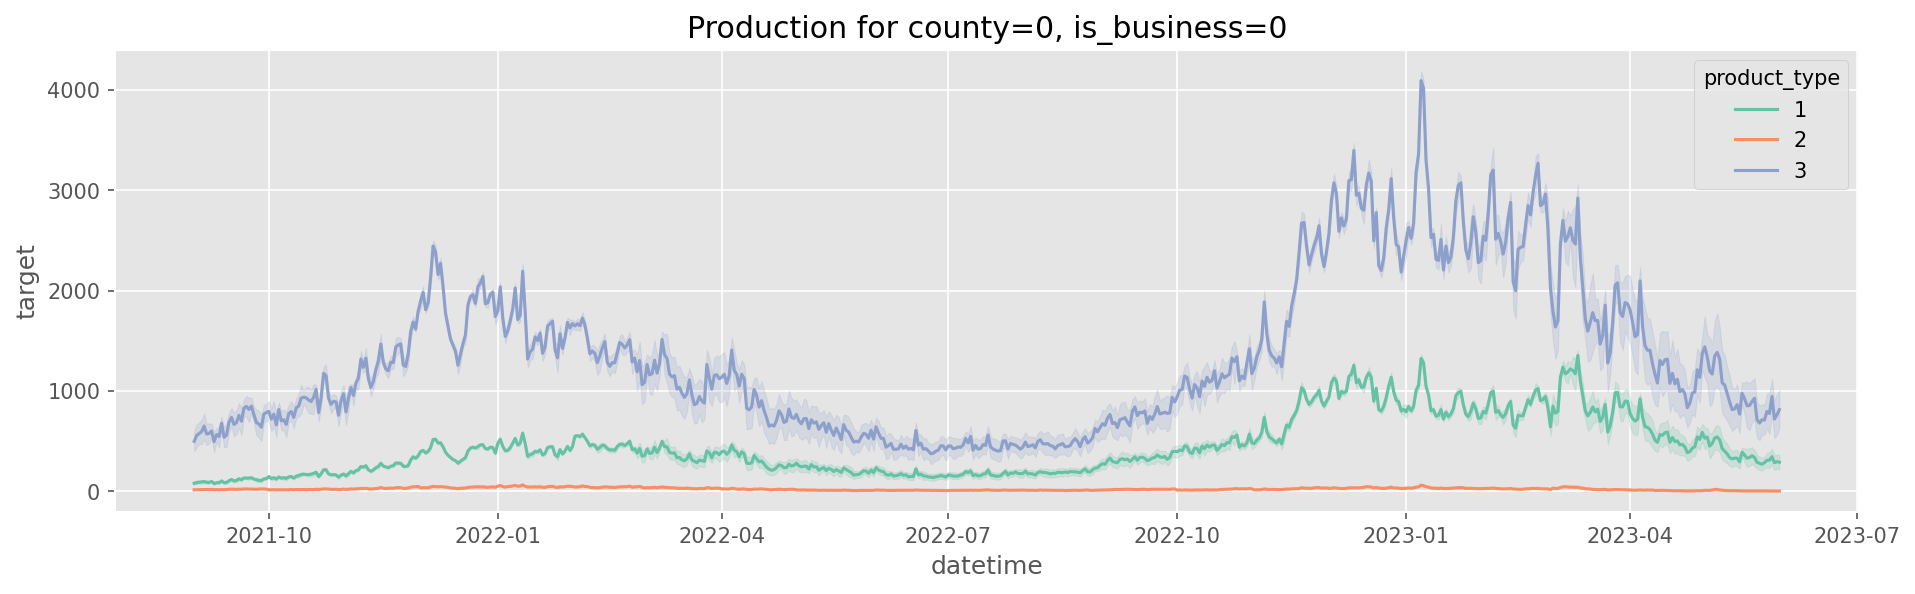

In [160]:
county = 0
is_business = 0
is_consumption = 1

df_plot = train[
    (train['county'] == county)
    & (train['is_business'] == is_business)
    & (train['is_consumption'] == is_consumption)
]
plt.figure(figsize=(15, 4))
sns.lineplot(data=df_plot, x=pd.to_datetime(df_plot['datetime']).dt.date, y="target", hue='product_type', palette='Set2')

plt.title(f'Production for county={county}, is_business={is_business}')
plt.show()


## Average production and consumption timeseries
### Daily Average

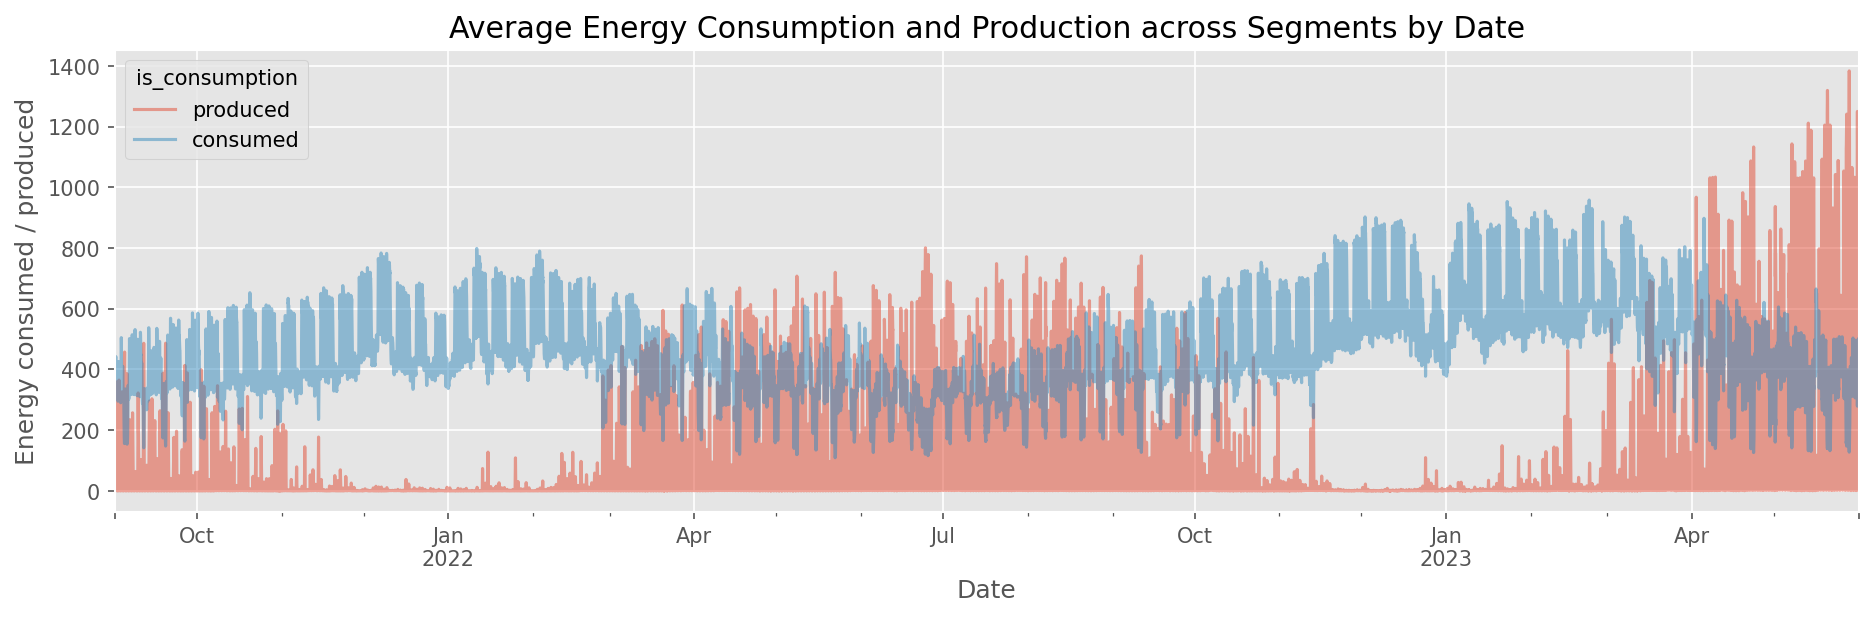

In [161]:
train_avgd = (
    train
    .groupby(['datetime','is_consumption'])
    ['target'].mean()
    .unstack()
    .rename({0: 'produced', 1:'consumed'}, axis=1)
)
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
_ = train_avgd.plot(ax=ax, alpha=0.5)
_ = ax.set_ylabel('Energy consumed / produced')
_ = ax.set_xlabel('Date')  
_ = ax.set_title('Average Energy Consumption and Production across Segments by Date')

plt.show()


### Monthly averages for the same series

From the following plot, we can see the consumptions peaks in either January or February and is the least in the summer months
The reverse is true for the production series

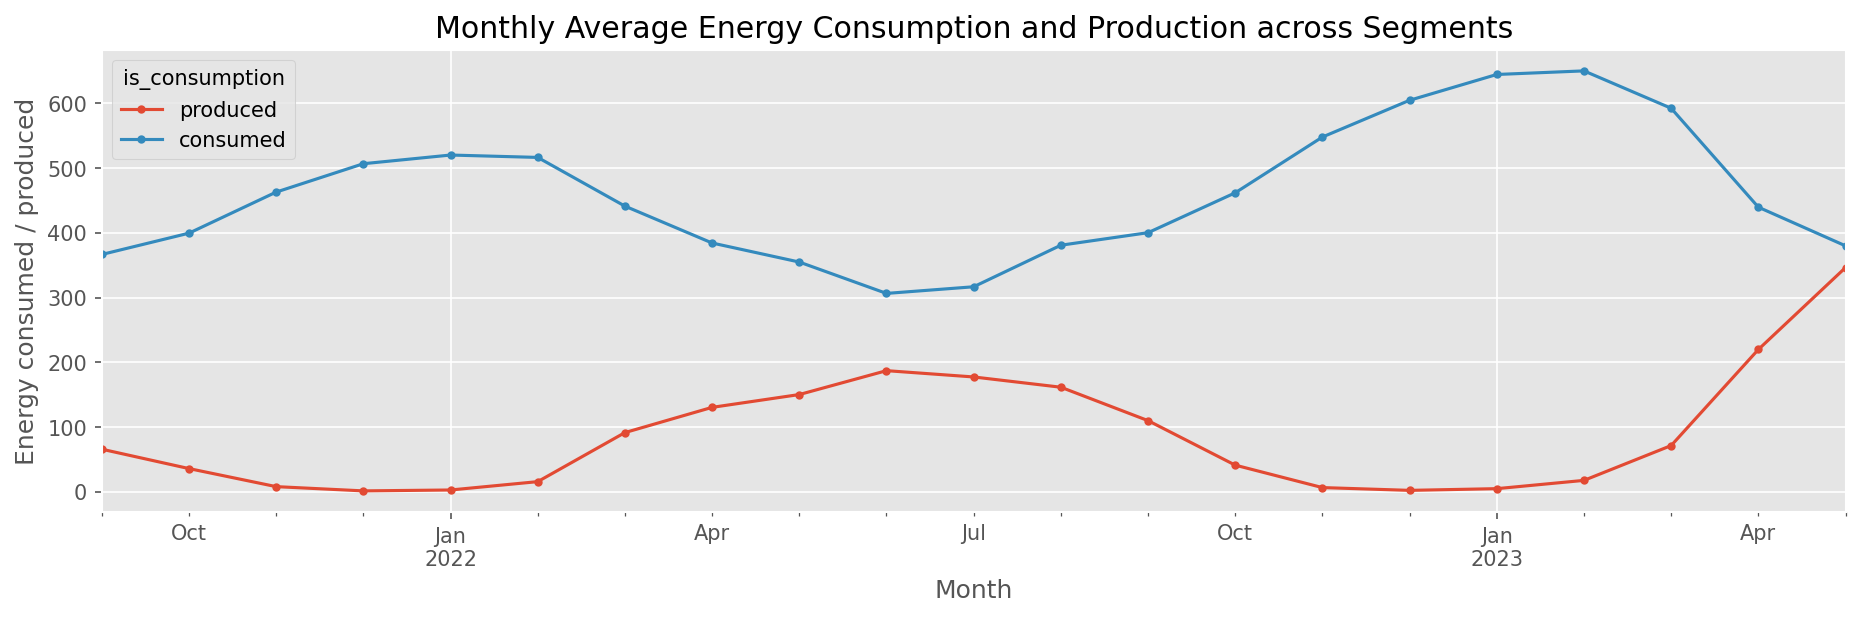

In [162]:
# plot of average weekly sales
fig,ax = plt.subplots(1,1,figsize=(15,4))
_ = train_avgd.resample('M').mean().plot(ax=ax, marker='.')
_ = ax.set_ylabel('Energy consumed / produced')
_ = ax.set_xlabel('Month')  
_ = ax.set_title('Monthly Average Energy Consumption and Production across Segments')

### Hourly Average

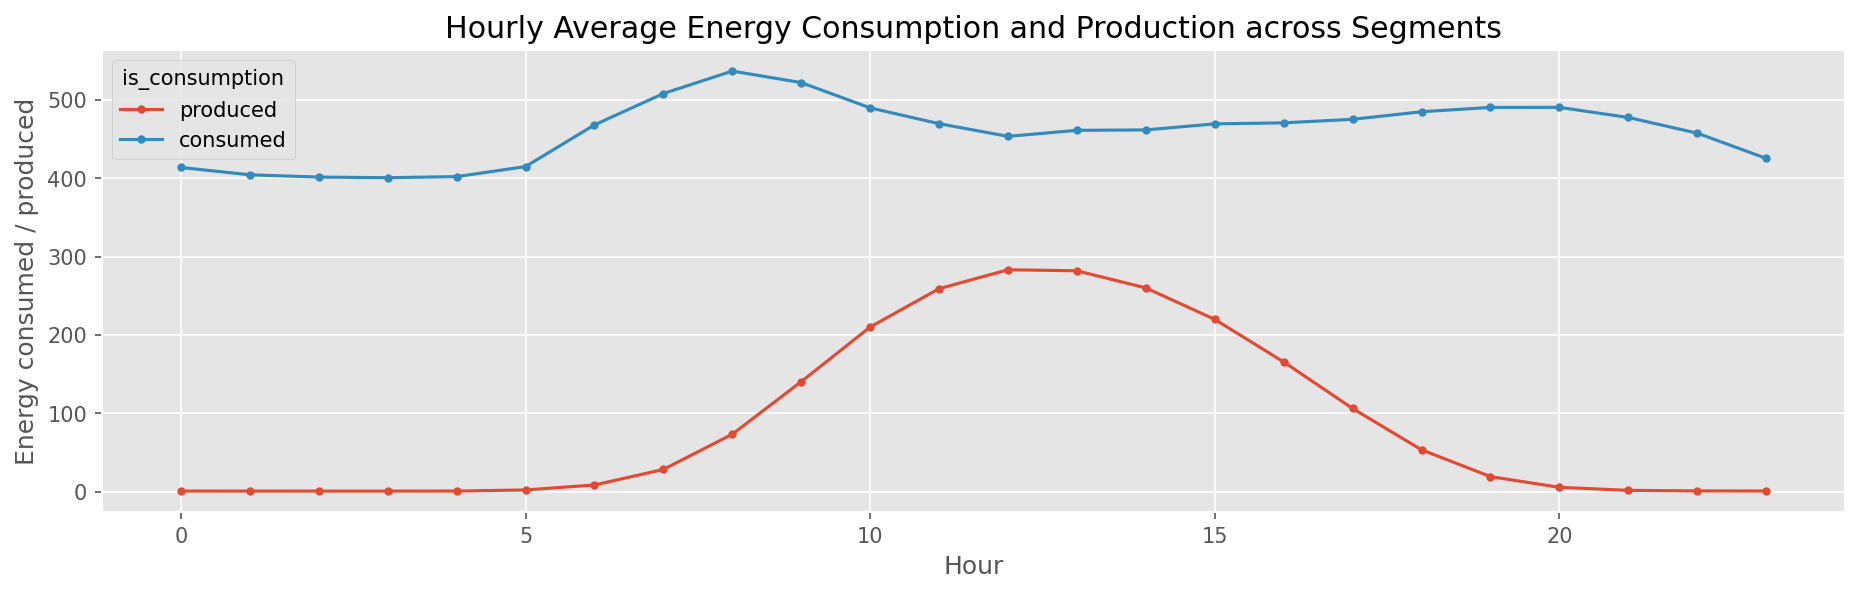

In [163]:
fig,ax = plt.subplots(1,1,figsize=(15,4))
train_avgd.groupby(train_avgd.index.hour).mean().plot(ax=ax, marker='.')
_ = ax.set_xlabel('Hour')
_ = ax.set_ylabel('Energy consumed / produced')
_ = ax.set_title('Hourly Average Energy Consumption and Production across Segments')

## Visualize Weather stations over Estonia counties

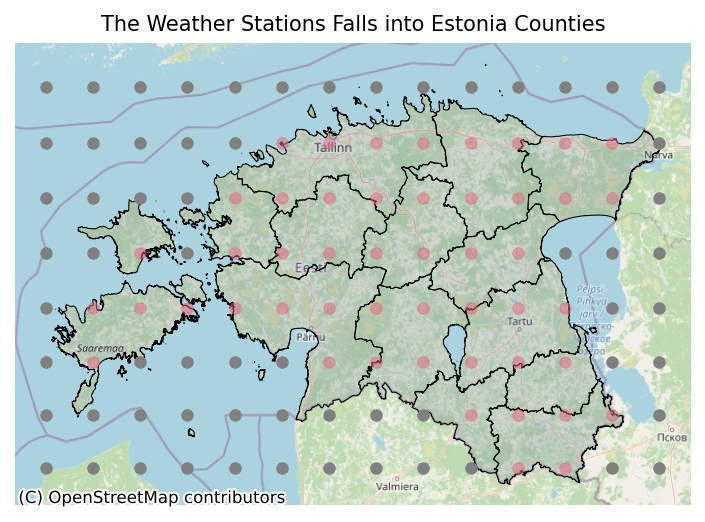

In [5]:
# Convert the station data into a GeoDataFrame
gdf_stations = gpd.GeoDataFrame(
    locations,
    geometry=gpd.points_from_xy(locations.longitude, locations.latitude),
    crs="EPSG:4326"
)

# Reproject the counties and station data to Web Mercator
counties = counties.to_crs(epsg=3857)
gdf_stations = gdf_stations.to_crs(epsg=3857)

# Check if each station is within a county
gdf_stations['in_county'] = gdf_stations.apply(lambda row: counties.contains(row['geometry']).any(), axis=1)

# Create the plot
fig, ax = plt.subplots(figsize=(15,4))
counties.plot(ax=ax, color=(0.3, 0.4, 0.5, 0.2), edgecolor='black')

# Plot the stations, differentiating those in the ocean
gdf_stations[gdf_stations['in_county']].plot(ax=ax, color=(0.9, 0.4, 0.5, 0.5), markersize=30)  # Not in ocean
gdf_stations[~gdf_stations['in_county']].plot(ax=ax, color='grey', markersize=30)  # In ocean

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Format the plot
ax.axis('off')
plt.title('The Weather Stations Falls into Estonia Counties', fontsize=10)
plt.show()


From the map above we can see some weather stations fall into ocean area (as shown in grey dots)

# Pre-Train Data Processing
**Baseline was taken from** [this notebook](https://www.kaggle.com/code/vyacheslavbolotin/lb-66-82/notebook)

In [43]:
def feat_eng_train(data, client, hist_weather,forecast_weather, electricity, gas, locations):
    ##### Train data
    #Dropping (target) nan values
    data= data[data['target'].notnull()] 
    #Converting (datetime) column to datetime --MC
    data['datetime'] = data['datetime'].dt.tz_localize('UTC')

    ##### Electricity data
    #Renaming (forecast_date) to (datetime) for merging with the train data later
    electricity = electricity.rename(columns= {'forecast_date' : 'datetime'})
    #Converting (datetime) column to datetime
    electricity['datetime'] = pd.to_datetime(electricity['datetime'], utc= True)

    #Decreasing (data_block_id) in client data because it's 2 steps ahead from train's data (data_block_id)
    # client['data_block_id'] -= 2  --MC
    
    ##### locations data
    # locations = locations.rename(columns= {'County ID' : 'county'})
    locations.drop(['county_name'], axis=1, inplace= True)
    ##### Forecast weather data
    #Rounding the (latitude) and (longitude) for 1 decimal fraction
    forecast_weather[['latitude', 'longitude']] = forecast_weather[['latitude','longitude']].astype(float).round(1)
    #Merging counties in locations data with the coordinations in the forecast_weather data
    forecast_weather= forecast_weather.merge(locations, how='left',on=['longitude','latitude'])
    #dropping nan values
    forecast_weather.dropna(axis= 0, inplace= True)    
    #Converting (county) column to integer
    forecast_weather['county'] = forecast_weather['county'].astype('int64')
    #Dropping the columns we won't need | We will use the (forecast_datetime) column instead of the (origin_datetime)
    forecast_weather.drop(['origin_datetime', 'latitude','longitude', 'hours_ahead', 'data_block_id'], axis=1, inplace= True)
    #Renaming (forecast_datetime) to (datetime) for merging with the train data later
    forecast_weather.rename(columns={'forecast_datetime': 'datetime'}, inplace= True)
    #Converting (datetime) column to datetime
    forecast_weather['datetime']= pd.to_datetime(forecast_weather['datetime'], utc= True)
    forecast_weather_datetime= forecast_weather.groupby([forecast_weather['datetime'].dt.to_period('h')])[list(forecast_weather.drop(['county','datetime'], axis= 1).columns)].mean().reset_index()
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    forecast_weather_datetime['datetime']= pd.to_datetime(forecast_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    forecast_weather_datetime_county= forecast_weather.groupby(['county',forecast_weather['datetime'].dt.to_period('h')])[list(forecast_weather.drop(['county','datetime'], axis= 1).columns)].mean().reset_index()
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    forecast_weather_datetime_county['datetime']= pd.to_datetime(forecast_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)

    ##### Historical weather data
    #Rounding the (latitude) and (longitude) for 1 decimal fraction           
    hist_weather[['latitude', 'longitude']] = hist_weather[['latitude', 'longitude']].astype(float).round(1)
    #Merging counties in locations data with the coordinations in the historical_weather data
    hist_weather= hist_weather.merge(locations, how='left', on=['longitude','latitude'])    
    #Dropping nan values
    hist_weather.dropna(axis= 0, inplace= True)
    #Dropping the columns we won't need
    hist_weather.drop(['latitude', 'longitude'], axis=1, inplace= True)
    #Converting (county) to integer
    hist_weather['county'] = hist_weather['county'].astype('int64')
    #Converting (datetime) column to datetime
    hist_weather['datetime']= pd.to_datetime(hist_weather['datetime'], utc= True)
    hist_weather_datetime= hist_weather.groupby([hist_weather['datetime'].dt.to_period('h')])[list(hist_weather.drop(['county','datetime','data_block_id'], axis= 1).columns)].mean().reset_index()    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    hist_weather_datetime['datetime']= pd.to_datetime(hist_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    #Merging (data_block_id) back after dropping it in the last step | (data_block_id will be used to merge with train data)
    hist_weather_datetime= hist_weather_datetime.merge(hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    hist_weather_datetime_county= hist_weather.groupby(['county',hist_weather['datetime'].dt.to_period('h')])[list(hist_weather.drop(['county','datetime', 'data_block_id'], axis= 1).columns)].mean().reset_index() 
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    hist_weather_datetime_county['datetime']= pd.to_datetime(hist_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)
    #Merging (data_block_id) back after dropping it in the last step
    hist_weather_datetime_county= hist_weather_datetime_county.merge(hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    #Adding hour column and drop datetime column
    hist_weather_datetime['hour']= hist_weather_datetime['datetime'].dt.hour
    hist_weather_datetime_county['hour']= hist_weather_datetime_county['datetime'].dt.hour
    hist_weather_datetime.drop_duplicates(inplace=True)
    hist_weather_datetime_county.drop_duplicates(inplace=True)
    hist_weather_datetime.drop('datetime', axis= 1, inplace= True)
    hist_weather_datetime_county.drop('datetime', axis= 1, inplace= True)


    ##### Adding time features
    #Adding year column in train data
    data['year'] = data['datetime'].dt.year
    #Adding month column in train data
    data['month'] = data['datetime'].dt.month
    #Adding day column in train data
    data['day'] = data['datetime'].dt.day
    #Adding hour column in train data
    data['hour'] = data['datetime'].dt.hour
    #Adding dayofweek column in train data
    data['dayofweek'] = data['datetime'].dt.dayofweek
    #Adding dayofyear column in train data
    data['dayofyear']= data['datetime'].dt.dayofyear
    #Adding hour column to electricity used to merge with the train data
    electricity['hour'] = electricity['datetime'].dt.hour

    ##### Merging train data with other available data
    data= data.merge(client.drop(columns = ['date']), how='left', on=['data_block_id', 'county', 'is_business', 'product_type'])
    data= data.merge(gas[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    data= data.merge(electricity[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour', 'data_block_id'])
    data= data.merge(forecast_weather_datetime, how='left', on=['datetime'])
    data= data.merge(forecast_weather_datetime_county, how='left', on=['datetime', 'county'],suffixes= ('_fcast_mean','_fcast_mean_by_county'))
    data= data.merge(hist_weather_datetime, how='left', on=['data_block_id', 'hour'])
    data= data.merge(hist_weather_datetime_county, how='left', on=['data_block_id', 'county', 'hour'],suffixes= ('_hist_mean','_hist_mean_by_county'))
    data= data.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()
    
    ##### Add Estonia holidays
    holidays_dict = {
    2022: ['2022-01-01', '2022-02-24', '2022-04-15', '2022-04-17', '2022-05-01', '2022-06-05',
           '2022-06-23', '2022-06-24', '2022-08-20', '2022-12-25', '2022-12-26'],
    2023: ['2023-01-01', '2023-02-24', '2023-04-07', '2023-04-09', '2023-05-01', '2023-05-28',
           '2023-06-23', '2023-06-24', '2023-08-20', '2023-12-25', '2023-12-26'],
    2024: ['2024-01-01', '2024-02-24', '2024-03-29', '2024-03-31', '2024-05-01', '2024-05-19',
           '2024-06-23', '2024-06-24', '2024-08-20', '2024-12-25', '2024-12-26']
    }
    # Function to check if a date is a holiday
    def is_holiday(date):
        year = date.year
        return date.strftime('%Y-%m-%d') in holidays_dict.get(year, [])
    
    # Apply the function to create 'is_holiday' column
    data['is_holiday'] = data['datetime'].apply(is_holiday)

    ##### Dropping unneeded data
    data.drop(['level_0', 'level_1', 'row_id', 'data_block_id'], axis= 1, inplace= True)
    return data

def create_revealed_targets_train(data, N_day_lags):

    original_datetime = data['datetime']
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    #Create revealed targets for n days lags
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

def get_agg_target_lag(df):
    
    tgt_lag_columns = [c for c in df.columns if '_days_ago' in c]
    
    for m in ['mean', 'std', 'var', 'median', 'max', 'min']:
        df[f'target_{m}'] = df[tgt_lag_columns].agg(m, axis=1)
        
    return df

#Applying the Train function and storing our train data in the (train) variable
train= feat_eng_train(train, client_df, hw_df, fw_df, electricity_df, gas_df, locations)
#Specify how many days to lag and applying the function
N_day_lags = 7
train = create_revealed_targets_train(train, N_day_lags = N_day_lags)
train['datetime'] = train['datetime'].astype('int64')

# Data Transformation

In [44]:
#Data transformation
train['sin_hour']= (np.pi * np.sin(train['hour']) / 12)
train['cos_hour']= (np.pi * np.cos(train['hour']) / 12)
train['sin_dayofyear']= (np.pi * np.sin(train['dayofyear']) / 183)
train['cos_dayofyear']= (np.pi * np.cos(train['dayofyear']) / 183)
train = get_agg_target_lag(train)

In [45]:
#Log columns with outliers
to_log= ['installed_capacity', 'euros_per_mwh', 'temperature_fcast_mean', 'dewpoint_fcast_mean',
        'cloudcover_high_fcast_mean', 'cloudcover_low_fcast_mean', 'cloudcover_mid_fcast_mean', 'cloudcover_total_fcast_mean',
        '10_metre_u_wind_component_fcast_mean', '10_metre_v_wind_component_fcast_mean', 'direct_solar_radiation_fcast_mean',
        'snowfall_fcast_mean', 'total_precipitation_fcast_mean', 'temperature_fcast_mean_by_county', 'dewpoint_fcast_mean_by_county',
        'cloudcover_high_fcast_mean_by_county', 'cloudcover_low_fcast_mean_by_county', 'cloudcover_mid_fcast_mean_by_county',
        'cloudcover_total_fcast_mean_by_county', '10_metre_u_wind_component_fcast_mean_by_county', '10_metre_v_wind_component_fcast_mean_by_county',
        'surface_solar_radiation_downwards_fcast_mean_by_county', 'snowfall_fcast_mean_by_county', 'total_precipitation_fcast_mean_by_county',
        'rain_hist_mean', 'snowfall_hist_mean', 'windspeed_10m_hist_mean_by_county', 'target_2_days_ago', 'target_3_days_ago',
        'target_4_days_ago', 'target_5_days_ago', 'target_6_days_ago', 'target_7_days_ago', 'target_mean', 'target_std']
for i in to_log:
    train[f"log_{i}"]= np.where((train[i])!= 0, np.log(train[i]),0)

# Trainging columns

In [46]:
#Storing training features into numpy arrays
X= train[train['is_consumption'] != 0].drop('target', axis= 1).values
y= train[train['is_consumption'] != 0]['target']

#Storing production targets into an array itself | Will seperate it into another model
X2= train[train['is_consumption'] == 0].drop('target', axis= 1).values
y2= train[train['is_consumption'] == 0]['target']

p_1={'n_iter':4000,'verbose': -1,'random_state':73,'objective':'tweedie','learning_rate': 0.004811751415536496, 'colsample_bytree': 0.8841841689852410, 'colsample_bynode': 0.4305836942635745, 'reg_alpha': 3.11984157361821, 'reg_lambda': 1.088469732297296, 'min_data_in_leaf': 162, 'max_depth': 16,'device':'cpu' , 'num_leaves': 435,'n_jobs':4}
p0 ={'n_iter':4000,'verbose': -1,'random_state':73,'objective':'tweedie','learning_rate': 0.007922862526647507, 'colsample_bytree': 0.9052952790963521, 'colsample_bynode': 0.4416947152746856, 'reg_alpha': 3.31471952672932, 'reg_lambda': 1.349570843308307, 'min_data_in_leaf': 185, 'max_depth': 18,'device':'cpu' , 'num_leaves': 445,'n_jobs':4}
p1 ={'n_iter':4000,'verbose': -1,'random_state':73,'objective':'tweedie','learning_rate': 0.010339736147758608, 'colsample_bytree': 0.9263063801074632, 'colsample_bynode': 0.4527058263857967, 'reg_alpha': 3.62802063709343, 'reg_lambda': 1.650681954419419, 'min_data_in_leaf': 201, 'max_depth': 20,'device':'cpu' , 'num_leaves': 455,'n_jobs':4}
p2 ={'n_iter':4000,'verbose': -1,'random_state':73,'objective':'tweedie','learning_rate': 0.013090718804096083, 'colsample_bytree': 0.9499770953943448, 'colsample_bynode': 0.4670163857441046, 'reg_aplha': 3.96946065556807, 'reg_lambda': 1.925712107567988, 'min_data_in_leaf': 223, 'max_depth': 22,'device':'cpu' , 'num_leaves': 465,'n_jobs':4}
p3 ={'n_iter':4000,'verbose': -1,'random_state':73,'objective':'tweedie','learning_rate': 0.015559490612977255, 'colsample_bytree': 0.9682791614810814, 'colsample_bynode': 0.4722023075509447, 'reg_aplha': 4.15624585398345, 'reg_lambda': 2.265053303366992, 'min_data_in_leaf': 254, 'max_depth': 24,'device':'cpu' , 'num_leaves': 475,'n_jobs':4}
p4 ={'n_iter':4000,'verbose': -1,'random_state':73,'objective':'tweedie','learning_rate': 0.018908744594789185, 'colsample_bytree': 0.9864875442500248, 'colsample_bynode': 0.4832525869590394, 'reg_aplha': 4.35845913192557, 'reg_lambda': 2.355521088983217, 'min_data_in_leaf': 289, 'max_depth': 26,'device':'cpu' , 'num_leaves': 485,'n_jobs':4}
p5 ={'n_iter':4000,'verbose': -1,'random_state':73,'objective':'tweedie','learning_rate': 0.021819855605890296, 'colsample_bytree': 0.9995986553611359, 'colsample_bynode': 0.4953634970601405, 'reg_alpha': 4.58956024201648, 'reg_lambda': 2.616432197094328, 'min_data_in_leaf': 309, 'max_depth': 28,'device':'cpu' , 'num_leaves': 495,'n_jobs':4}

lgbp_1=LGBMRegressor(**p_1)
lgbp0=LGBMRegressor(**p0)
lgbp1=LGBMRegressor(**p1)
lgbp2=LGBMRegressor(**p2)
lgbp3=LGBMRegressor(**p3)
lgbp4=LGBMRegressor(**p4)
lgbp5=LGBMRegressor(**p5)

n_1={'n_iter':4000,'verbose': -1,'random_state':73,'objective':'tweedie','learning_rate': 0.006311751415536496, 'colsample_bytree': 0.8441841689852410, 'colsample_bynode': 0.4305836942635745, 'lambda_l1': 3.21984157361821, 'lambda_l2': 1.108469732297296, 'min_data_in_leaf': 53, 'max_depth': 10,  'min_data_per_groups': 39,'device':'cpu' ,'num_leaves': 435,'n_jobs':4}
n0 ={'n_iter':4000,'verbose': -1,'random_state':73,'objective':'tweedie','learning_rate': 0.008228625036647597, 'colsample_bytree': 0.8652952790963521, 'colsample_bynode': 0.4416947152746856, 'lambda_l1': 3.41471952672932, 'lambda_l2': 1.349570843308307, 'min_data_in_leaf': 58, 'max_depth': 11,  'min_data_per_groups': 49,'device':'cpu' ,'num_leaves': 445,'n_jobs':4}
n1 ={'n_iter':4000,'verbose': -1,'random_state':73,'objective':'tweedie','learning_rate': 0.010339736147758608, 'colsample_bytree': 0.8893063801074632, 'colsample_bynode': 0.4527058263857967, 'lambda_l1': 3.62802063709343, 'lambda_l2': 1.650681954419419, 'min_data_in_leaf': 63, 'max_depth': 13,  'min_data_per_groups': 59,'device':'cpu' ,'num_leaves': 455,'n_jobs':4}
n2 ={'n_iter':4000,'verbose': -1,'random_state':73,'objective':'tweedie','learning_rate': 0.012090718804096083, 'colsample_bytree': 0.9099770953943448, 'colsample_bynode': 0.4670163857441046, 'lambda_l1': 3.86946065556807, 'lambda_l2': 1.925712107567988, 'min_data_in_leaf': 68, 'max_depth': 15,  'min_data_per_groups': 69,'device':'cpu' ,'num_leaves': 465,'n_jobs':4}
n3 ={'n_iter':4000,'verbose': -1,'random_state':73,'objective':'tweedie','learning_rate': 0.014559490612977255, 'colsample_bytree': 0.9282791614810814, 'colsample_bynode': 0.4722023075509447, 'lambda_l1': 4.05624585398343, 'lambda_l2': 2.265053303366992, 'min_data_in_leaf': 73, 'max_depth': 17,  'min_data_per_groups': 79,'device':'cpu' ,'num_leaves': 475,'n_jobs':4}
n4 ={'n_iter':4000,'verbose': -1,'random_state':73,'objective':'tweedie','learning_rate': 0.016908744594789185, 'colsample_bytree': 0.9534875442500248, 'colsample_bynode': 0.4832525869590394, 'lambda_l1': 4.25845913192557, 'lambda_l2': 2.555521088983217, 'min_data_in_leaf': 78, 'max_depth': 19,  'min_data_per_groups': 89,'device':'cpu' ,'num_leaves': 485,'n_jobs':4}
n5 ={'n_iter':4000,'verbose': -1,'random_state':73,'objective':'tweedie','learning_rate': 0.018819855605890296, 'colsample_bytree': 0.9715986553611359, 'colsample_bynode': 0.4953634970601405, 'lambda_l1': 4.58956024201648, 'lambda_l2': 2.816432197094328, 'min_data_in_leaf': 83, 'max_depth': 21,  'min_data_per_groups': 99,'device':'cpu' ,'num_leaves': 495,'n_jobs':4}

lgbn_1=LGBMRegressor(**n_1)
lgbn0=LGBMRegressor(**n0) 
lgbn1=LGBMRegressor(**n1)
lgbn2=LGBMRegressor(**n2)
lgbn3=LGBMRegressor(**n3)
lgbn4=LGBMRegressor(**n4)
lgbn5=LGBMRegressor(**n5)

# Training models

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Split your data
Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.25, random_state=73, shuffle=True)
X2tr, X2val, y2tr, y2val = train_test_split(X2, y2, test_size=0.25, random_state=73, shuffle=True)

In [49]:
for lgbm_model in [lgbp_1, lgbp0, lgbp1, lgbp2, lgbp3, lgbp4, lgbp5]: # v1
# for lgbm_model in [lgbp_1, lgbp1, lgbp2, lgbp3, lgbp4]:
    print('_______________________________________________________')
    print('Start')
    lgbm_model.fit(Xtr, ytr, eval_set=[(Xval, yval)], callbacks=[
            lgb.callback.early_stopping(stopping_rounds=50),
            lgb.callback.log_evaluation(period=100),
        ],)

_______________________________________________________
Start
Training until validation scores don't improve for 50 rounds
[100]	valid_0's tweedie: 73.0077
[200]	valid_0's tweedie: 66.5926
[300]	valid_0's tweedie: 63.6604
[400]	valid_0's tweedie: 62.397
[500]	valid_0's tweedie: 61.8674
[600]	valid_0's tweedie: 61.6419
[700]	valid_0's tweedie: 61.5395
[800]	valid_0's tweedie: 61.4872
[900]	valid_0's tweedie: 61.4558
[1000]	valid_0's tweedie: 61.4344
[1100]	valid_0's tweedie: 61.418
[1200]	valid_0's tweedie: 61.4037
[1300]	valid_0's tweedie: 61.3916
[1400]	valid_0's tweedie: 61.3808
[1500]	valid_0's tweedie: 61.3719
[1600]	valid_0's tweedie: 61.3644
[1700]	valid_0's tweedie: 61.3581
[1800]	valid_0's tweedie: 61.3525
[1900]	valid_0's tweedie: 61.3474
[2000]	valid_0's tweedie: 61.3428
[2100]	valid_0's tweedie: 61.3387
[2200]	valid_0's tweedie: 61.335
[2300]	valid_0's tweedie: 61.3316
[2400]	valid_0's tweedie: 61.3284
[2500]	valid_0's tweedie: 61.3254
[2600]	valid_0's tweedie: 61.3226
[2700

In [9]:
gc.collect()

594

In [10]:
for lgbm_model in [lgbn_1, lgbn0, lgbn1, lgbn2, lgbn3, lgbn4, lgbn5]: # v1
# for lgbm_model in [lgbn_1, lgbn1, lgbn2, lgbn3, lgbn4]:
    print('_______________________________________________________')
    print('Start')
    lgbm_model.fit(X2tr, y2tr, eval_set=[(X2val, y2val)], callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100),
        ],)

_______________________________________________________
Start
Training until validation scores don't improve for 100 rounds
[100]	valid_0's tweedie: 26.8301
[200]	valid_0's tweedie: 21.8875
[300]	valid_0's tweedie: 19.7144
[400]	valid_0's tweedie: 18.7617
[500]	valid_0's tweedie: 18.3296
[600]	valid_0's tweedie: 18.1219
[700]	valid_0's tweedie: 18.014
[800]	valid_0's tweedie: 17.9513
[900]	valid_0's tweedie: 17.9111
[1000]	valid_0's tweedie: 17.8823
[1100]	valid_0's tweedie: 17.8597
[1200]	valid_0's tweedie: 17.8419
[1300]	valid_0's tweedie: 17.8265
[1400]	valid_0's tweedie: 17.8108
[1500]	valid_0's tweedie: 17.7972
[1600]	valid_0's tweedie: 17.7854
[1700]	valid_0's tweedie: 17.7753
[1800]	valid_0's tweedie: 17.7659
[1900]	valid_0's tweedie: 17.7575
[2000]	valid_0's tweedie: 17.7492
[2100]	valid_0's tweedie: 17.7419
[2200]	valid_0's tweedie: 17.7353
[2300]	valid_0's tweedie: 17.7288
[2400]	valid_0's tweedie: 17.7234
[2500]	valid_0's tweedie: 17.7183
[2600]	valid_0's tweedie: 17.7135
[2

In [11]:
gc.collect()

333

# Test Function

In [12]:
def feat_eng_test(data, client, hist_weather, forecast_weather, electricity, gas, locations):
    
    data= data.rename(columns={'prediction_datetime' : 'datetime'})
    data['datetime'] = pd.to_datetime(data['datetime'], utc=True)
    electricity = electricity.rename(columns= {'forecast_date' : 'datetime'})
    electricity['datetime'] = pd.to_datetime(electricity['datetime'], utc= True)
    locations = locations.drop('Unnamed: 0', axis= 1) 
    forecast_weather[['latitude', 'longitude']] = forecast_weather[['latitude', 'longitude']].astype(float).round(1)
    forecast_weather= forecast_weather.merge(locations, how='left', on=['longitude','latitude'])
    forecast_weather.dropna(axis= 0, inplace= True)    
    forecast_weather['county'] = forecast_weather['county'].astype('int64')
    forecast_weather.drop(['origin_datetime', 'latitude', 'longitude', 'hours_ahead', 'data_block_id'], axis=1, inplace= True)
    forecast_weather.rename(columns={'forecast_datetime': 'datetime'}, inplace= True)
    forecast_weather['datetime']= pd.to_datetime(forecast_weather['datetime'], utc= True)
    forecast_weather_datetime= forecast_weather.groupby([forecast_weather['datetime'].
                                            dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                                            'datetime'], axis= 1)
                                                                     .columns)].mean().reset_index()
    forecast_weather_datetime['datetime']= pd.to_datetime(
        forecast_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    forecast_weather_datetime_county= forecast_weather.groupby(['county',forecast_weather['datetime'].
                              dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                              'datetime'], axis= 1)
                                                       .columns)].mean().reset_index()
    forecast_weather_datetime_county['datetime']= pd.to_datetime(
        forecast_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)

                
    hist_weather[['latitude', 'longitude']] = hist_weather[['latitude', 'longitude']].astype(float).round(1)

    hist_weather= hist_weather.merge(locations, how='left', on=['longitude','latitude'])    
    
    hist_weather.dropna(axis= 0, inplace= True)
    
    hist_weather.drop(['latitude', 'longitude'], axis=1, inplace= True)

    hist_weather['county'] = hist_weather['county'].astype('int64')
            
    hist_weather['datetime']= pd.to_datetime(hist_weather['datetime'], utc= True)

    hist_weather_datetime= hist_weather.groupby([hist_weather['datetime'].
                                            dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                                            'datetime', 'data_block_id'], axis= 1)
                                                                     .columns)].mean().reset_index()    
    
    hist_weather_datetime['datetime']= pd.to_datetime(hist_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    hist_weather_datetime= hist_weather_datetime.merge(hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    
    hist_weather_datetime_county= hist_weather.groupby(['county',hist_weather['datetime'].
                              dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                              'datetime', 'data_block_id'], axis= 1)
                                                       .columns)].mean().reset_index() 
    hist_weather_datetime_county['datetime']= pd.to_datetime(hist_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)
    hist_weather_datetime_county= hist_weather_datetime_county.merge(hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    data['year'] = data['datetime'].dt.year
    data['month'] = data['datetime'].dt.month
    data['day'] = data['datetime'].dt.day
    data['hour'] = data['datetime'].dt.hour
    data['dayofweek']= data['datetime'].dt.dayofweek
    data['dayofyear']= data['datetime'].dt.dayofyear

    electricity['hour'] = electricity['datetime'].dt.hour

    
    data= data.merge(client.drop(columns = ['date']), how='left', on=['data_block_id', 'county', 'is_business', 'product_type'])
    data= data.merge(gas[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    data= data.merge(electricity[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour', 'data_block_id'])
    data= data.merge(forecast_weather_datetime, how='left', on=['datetime'])
    data= data.merge(forecast_weather_datetime_county, how='left', on=['datetime', 'county'],
                     suffixes= ('_fcast_mean','_fcast_mean_by_county'))
    
    hist_weather_datetime['hour']= hist_weather_datetime['datetime'].dt.hour
    hist_weather_datetime_county['hour']= hist_weather_datetime_county['datetime'].dt.hour

    hist_weather_datetime.drop_duplicates(inplace=True)
    hist_weather_datetime_county.drop_duplicates(inplace=True)
    hist_weather_datetime.drop('datetime', axis= 1, inplace= True)
    hist_weather_datetime_county.drop('datetime', axis= 1, inplace= True)

    
    data= data.merge(hist_weather_datetime, how='left', on=['data_block_id', 'hour'])
    data= data.merge(hist_weather_datetime_county, how='left', on=['data_block_id', 'county', 'hour'],
                     suffixes= ('_hist_mean','_hist_mean_by_county'))

    data= data.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()

    data.drop(['level_0', 'level_1', 'row_id', 'data_block_id'], axis= 1, inplace= True)
    
    return data


In [13]:
def create_revealed_targets_test(data, previous_revealed_targets, N_day_lags):
#    🎯 Create new test data based on previous_revealed_targets and N_day_lags 🎯 
    for count, revealed_targets in enumerate(previous_revealed_targets) :
        day_lag = count + 2
        # Get hour
        revealed_targets['hour'] = pd.to_datetime(revealed_targets['datetime'], utc= True).dt.hour
        # Select columns and rename target
        revealed_targets = revealed_targets[['hour', 'prediction_unit_id', 'is_consumption', 'target']]
        revealed_targets = revealed_targets.rename(columns = {"target" : f"target_{day_lag}_days_ago"})
        # Add past revealed targets
        data = pd.merge(data,
                        revealed_targets,
                        how = 'left',
                        on = ['hour', 'prediction_unit_id', 'is_consumption'],
                       )
        
    # If revealed_target_columns not available, replace by nan
    all_revealed_columns = [f"target_{day_lag}_days_ago" for day_lag in range(2, N_day_lags+1)]
    missing_columns = list(set(all_revealed_columns) - set(data.columns))
    data[missing_columns] = np.nan 
    
    return data

# Submission

In [ ]:
previous_revealed_targets = []
env = enefit.make_env()
iter_test = env.iter_test()
for (test, revealed_targets, client_test, historical_weather_test,
     forecast_weather_test, electricity_test, gas_test,sample_prediction) in iter_test:
    
    # Rename test set to make consistent with train
    test = test.rename(columns = {'prediction_datetime': 'datetime'})
    
    # Initiate column data_block_id with default value to merge the data on
    id_column = 'data_block_id' 
    
    test[id_column] = 0
    gas_test[id_column] = 0
    electricity_test[id_column] = 0
    historical_weather_test[id_column] = 0
    forecast_weather_test[id_column] = 0
    client_test[id_column] = 0
    revealed_targets[id_column] = 0
    
    data_test = feat_eng_test(test, client_test, historical_weather_test,forecast_weather_test, electricity_test, gas_test, locations)
    
    data_test['datetime']= pd.to_datetime(data_test['datetime'], utc= True).astype('int64')
    
    # Store revealed_targets
    previous_revealed_targets.insert(0, revealed_targets)
    if len(previous_revealed_targets) == N_day_lags:
        previous_revealed_targets.pop()
    
    # Add previous revealed targets
    df_test = create_revealed_targets_test(data = data_test.copy(),previous_revealed_targets = previous_revealed_targets.copy(),N_day_lags = N_day_lags)
    #Data Transformation
    df_test['sin_hour']= (np.pi * np.sin(df_test['hour']) / 12)
    df_test['cos_hour']= (np.pi * np.cos(df_test['hour']) / 12)
    df_test['sin_hour']= (np.pi * np.sin(df_test['hour']) / 12)
    df_test['cos_hour']= (np.pi * np.cos(df_test['hour']) / 12)
    df_test['sin_dayofyear']= (np.pi * np.sin(df_test['dayofyear']) / 183)
    df_test['cos_dayofyear']= (np.pi * np.cos(df_test['dayofyear']) / 183)
    df_test = get_agg_target_lag(df_test)
        
    for i in to_log:
        df_test[f"log_{i}"]= np.where((df_test[i])!= 0, np.log(df_test[i]),0)
    X_test = df_test.drop('currently_scored', axis= 1).values

    #Predictions
    #create a list to store predictions of each model
    target_list=[]
    
    # mod_weights = [0.12,0.13,0.17,0.16,0.15,0.14,0.13] - original
    
    mod_weights = [0.125, 0.125, 0.14, 0.14, 0.145, 0.155, 0.17] # - version 1
    
    # mod_weights = [0.18, 0.22, 0.20, 0.21, 0.19] # - version 2
    
    # mod_weights = [0.18, 0.19, 0.20, 0.21, 0.22] # - version 3
    
    #                                          # - version 4 continue .. 8 est .. 7 + 1
    
    #                                          # - version 5 continue .. 8 est .. 4 + 1
        
    for mod in [lgbp_1, lgbp0, lgbp1, lgbp2, lgbp3, lgbp4, lgbp5]:
#     for mod in [lgbp_1, lgbp1, lgbp2, lgbp3, lgbp4]:
        target_list.append(mod.predict(X_test).clip(0))
    
    #weighted average
    
    pred=0
    for i in range(len(mod_weights)):
        pred += (target_list[i]* mod_weights[i])
        
    test['target'] = pred
    
    #repeat above process for target_solar
    tsolar_list=[]
    
    for mod in [lgbn_1, lgbn0, lgbn1, lgbn2, lgbn3, lgbn4, lgbn5]:
#     for mod in [lgbn_1, lgbn1, lgbn2, lgbn3, lgbn4]:
        tsolar_list.append(mod.predict(X_test).clip(0))
        
    pred_solar=0
    for i in range(len(mod_weights)):
        pred_solar += (tsolar_list[i]* mod_weights[i])
        
    test['target_solar'] = pred_solar
    
    gc.collect()
    
    test.loc[test['is_consumption']==0, "target"] = test.loc[test['is_consumption']==0, "target_solar"]  
    sample_prediction["target"] = test['target']
    
    #Sending predictions to the API
    env.predict(sample_prediction)